# Baseline Predictions
single step multivariate predictions

In [1]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read in the dataframe from the csv file
file = "/Volumes/SD.Card/ML_Data/Web Traffic/web-traffic-time-series-forecasting/train_1.csv"
data = pd.read_csv(file)
df = data.copy(deep=True)

In [3]:
df = df.fillna(0) # fill na just for our intial look
df.head(5)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# get our data and some info about it
data = df[25:26].values[0][1:-1]
data_length = len(data)
data_range = range(data_length)

Lets make some functions for each of our baseline forcasters.

In [6]:
def root_mean_squared_error(predicted):
    sum_error = 0.0
    for i in data_range:
        prediction_error = predicted[i] - data[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(data_length)
    return mean_error**.5

def offset_persistance(offset):
    """
    y(t+1) = y(t-offset)
    offset
    """
    predictions = []
    for i in data_range:
        try:
            prediction = data[i - offset]
        except:
            prediction = data[i]
        predictions.append(prediction)
    error = root_mean_squared_error(predictions)

    return predictions, error

def rolling_average(window):
    """
    y(t+1) = sum(y(t-window):y(t))/len(window)
    window
    """
    predictions = []
    for i in data_range:
        if i > window:
            prediction_set = data[i - window:i]
        else:
            prediction_set = data[i:i + 1]
        prediction = sum(prediction_set) / len(prediction_set)
        predictions.append(prediction)
    error = root_mean_squared_error(predictions)

    return predictions, error

def simple_exp_smoothing(alpha):
    """
    y(t+1)= alpha *y(t) + alpha(1-alpha)*y(t-1) + alpha(1-alpha^2)*y(t-2) ...
    alpha
    """
    predictions = []
    for i in data_range:
        smoothing_set = data[0:i]
        prediction = sum([alpha * (1 - alpha) ** i * x for i, x in enumerate(reversed(smoothing_set))])
        predictions.append(prediction)
    error = root_mean_squared_error(predictions)

    return predictions, error

def holts_smoothing(alpha, beta):
    """
    y(t+h) = l(t) + h*b(t)
    l(t) = alpha*y(t) + (1-alpha)(l(t-1) + b(t-1))
    b(t) = beta * (l(t) - l(t-1)) + (1-beta)b(t-1)
    alpha, beta, h
    """
    # fill in a few values to start
    level = [1]
    trend = [1]
    predictions = [data[0]]

    for i in data_range[1:]:
        level.append((alpha * data[i - 1]) + (1 - alpha) * (level[i - 1] + trend[i - 1]))
        trend.append(beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1])
        predictions.append(level[i] + trend[i])
    error = root_mean_squared_error(predictions)
    
    return predictions, error

def holt_winter_additive(alpha, beta, gamma, m):
    """
    y(t+h) = l(t) + h*b(t) + s(t+h-m(k+1))
    l(t) = alpha*(y(t) - s(t-m)) + (1-alpha)*(l(t-1)+b(t-1))
    b(t) = beta*(l(t)-l(t-1)) + (1-beta)*b(t-1)
    s(t) = gamma*(y(t)-l(t-1)-b(t-1))+(1-gamma)*s(t-m)
    alpha, beta, gamma, h=1, m
    """
    # fill in m values to start
    level = [1] * m
    trend = [1] * m
    season = [1] * m
    predictions = []
    
    for element in range((m)):
        predictions.append(data[element])

    for i in data_range[m:]:
        level.append(alpha * (data[i - 1] - season[i - m]) + (1 - alpha) * (level[i - 1] + trend[i - 1]))
        trend.append(beta * (level[i] - level[i - 1]) + (1 - beta) * trend[i - 1])
        season.append(gamma * (data[i - 1] - level[i - 1] - trend[i - 1] + (1 - gamma) * (season[i - m])))
        predictions.append(level[i] + trend[i] + season[i - m])
    error = root_mean_squared_error(predictions)

    return predictions, error

Now lets run the models, grab their predictions, and plot them all 

In [7]:
def run_models():
    
    hypers = {'persistance': [1],
              'rolling': [5],
              'simple_exp': [.2],
              'holt_exp': [.2, .1],
              'holt_winter_exp': [.2, .1, .2, 4]}

    persistance_pred, persistance_error = offset_persistance(*hypers['persistance'])  # [offset, search]
    rolling_avg_pred, rolling_avg_error = rolling_average(*hypers['rolling'])  # [window, search]
    simple_exp_pred, simple_exp_error = simple_exp_smoothing(*hypers['simple_exp'])  # [alpha, search]
    holt_exp_pred, holt_exp_error = holts_smoothing(*hypers['holt_exp'])  # [alpha,beta, search]
    holt_winter_exp_pred, holt_winter_exp_error = holt_winter_additive(*hypers['holt_winter_exp'])  # [alpha,beta,gamma,m, search]

    preds = {'persistance': persistance_pred,
             'rolling': rolling_avg_pred,
             'simple_exp': simple_exp_pred,
             'holt_exp': holt_exp_pred,
             'holt_winter_exp': holt_winter_exp_pred}

    errors = {'persistance': persistance_error,
              'rolling': rolling_avg_error,
              'simple_exp': simple_exp_error,
              'holt_exp': holt_exp_error,
              'holt_winter_exp': holt_winter_exp_error}

    return preds, errors

def plot_all(preds, errors):

    i = 10  # only start plotting after i values for forecasting
    fig = plt.figure(figsize=(35, 20))
    fig.set_facecolor('white')
    plt.style.use('seaborn-dark')
    plt.plot(data_range, data, 'b', linewidth=2, label='True Data')
    plt.plot(data_range[i:], preds['persistance'][i:],     'r--', label='Persistance offset, RMSE: %.2f' % errors['persistance'])
    plt.plot(data_range[i:], preds['rolling'][i:],         'g--', label='Rolling Average, RMSE: %.2f' % errors['rolling'])
    plt.plot(data_range[i:], preds['simple_exp'][i:],      'y--', label='Simple Smoothing, RMSE: %.2f' % errors['simple_exp'])
    plt.plot(data_range[i:], preds['holt_exp'][i:],        'm--', label='Holt Smoothing, RMSE: %.2f' % errors['holt_exp'])
    plt.plot(data_range[i:], preds['holt_winter_exp'][i:], 'k--', label='Holt Winter, RMSE: %.2f' % errors['holt_winter_exp'])
    plt.legend(loc=2, fontsize = 'xx-large')
    plt.show()


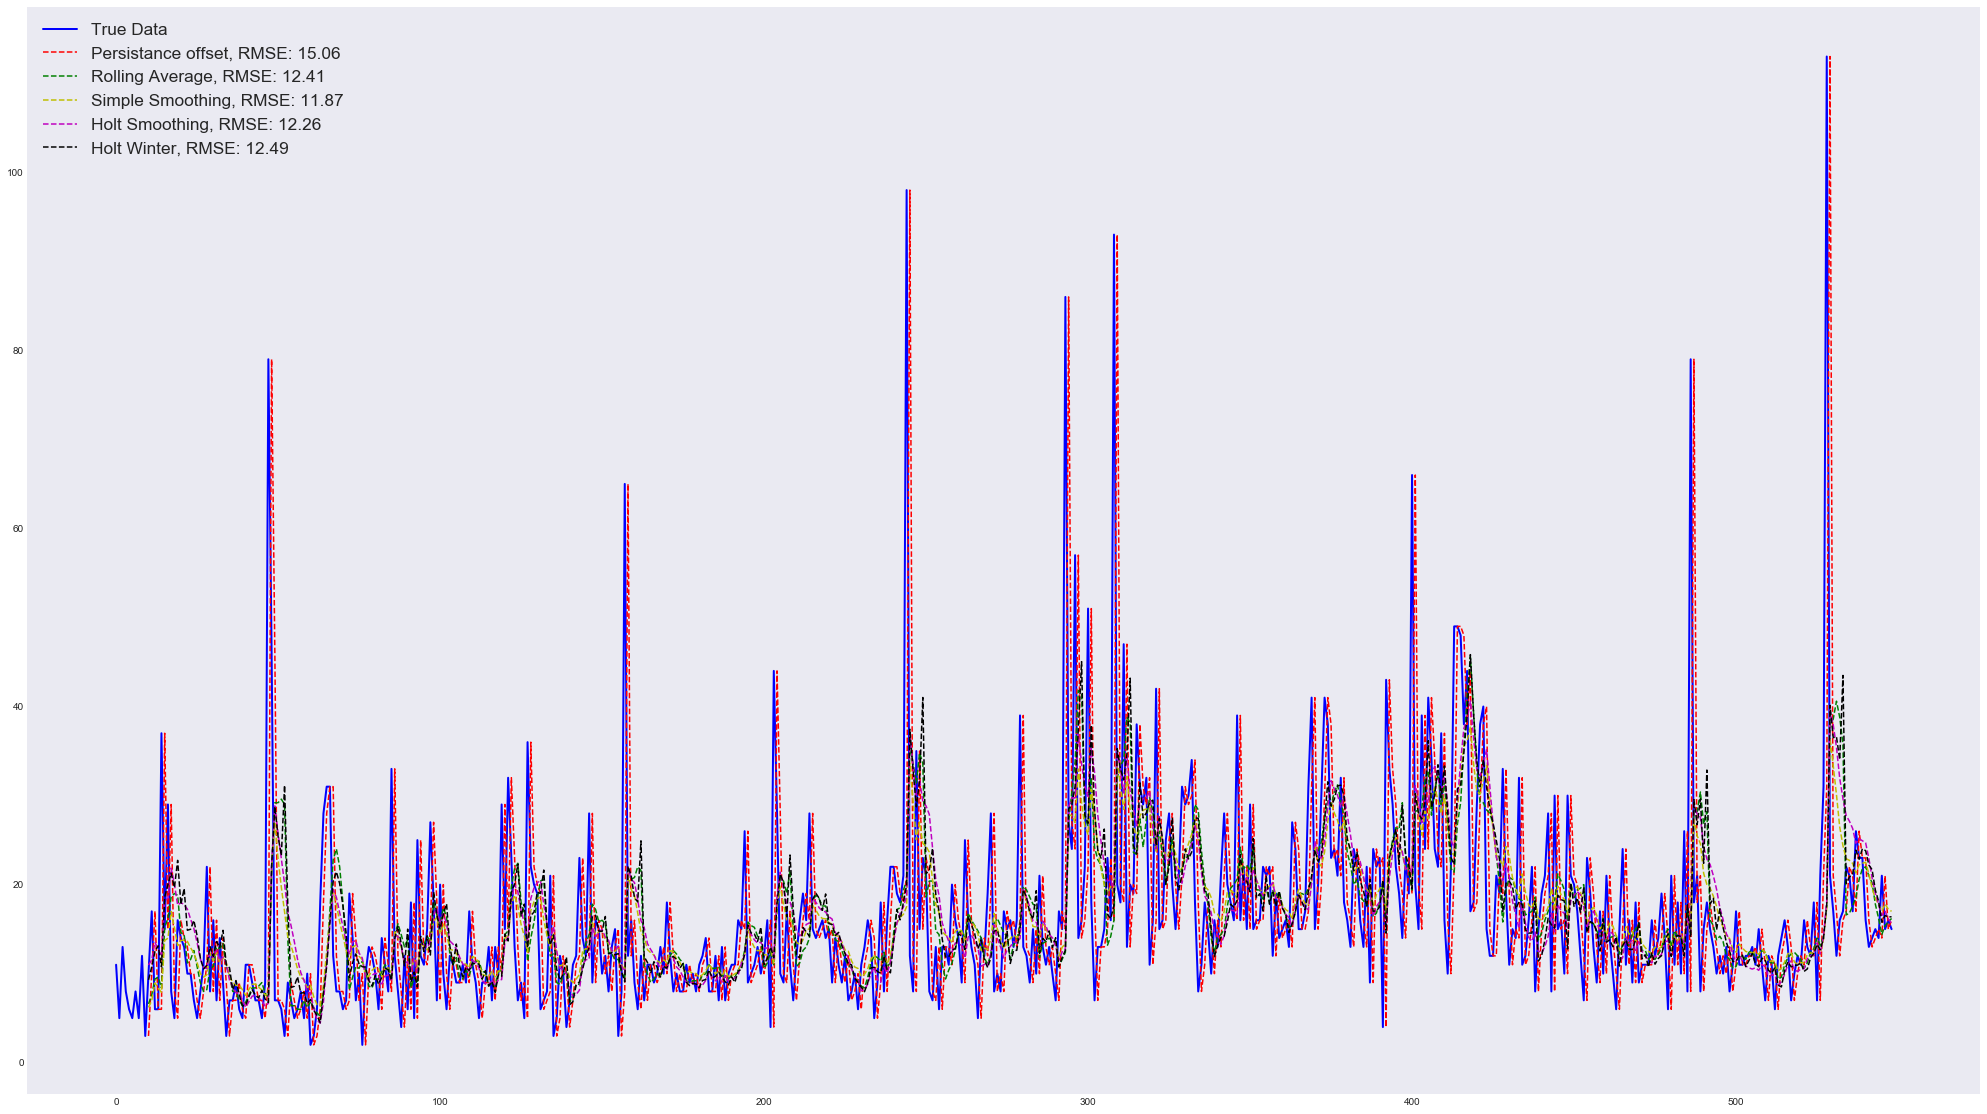

In [8]:
preds, error = run_models()
plot_all(preds, error)

Let's zoom in on a section of our time series to show the nuanaces of each prediction method

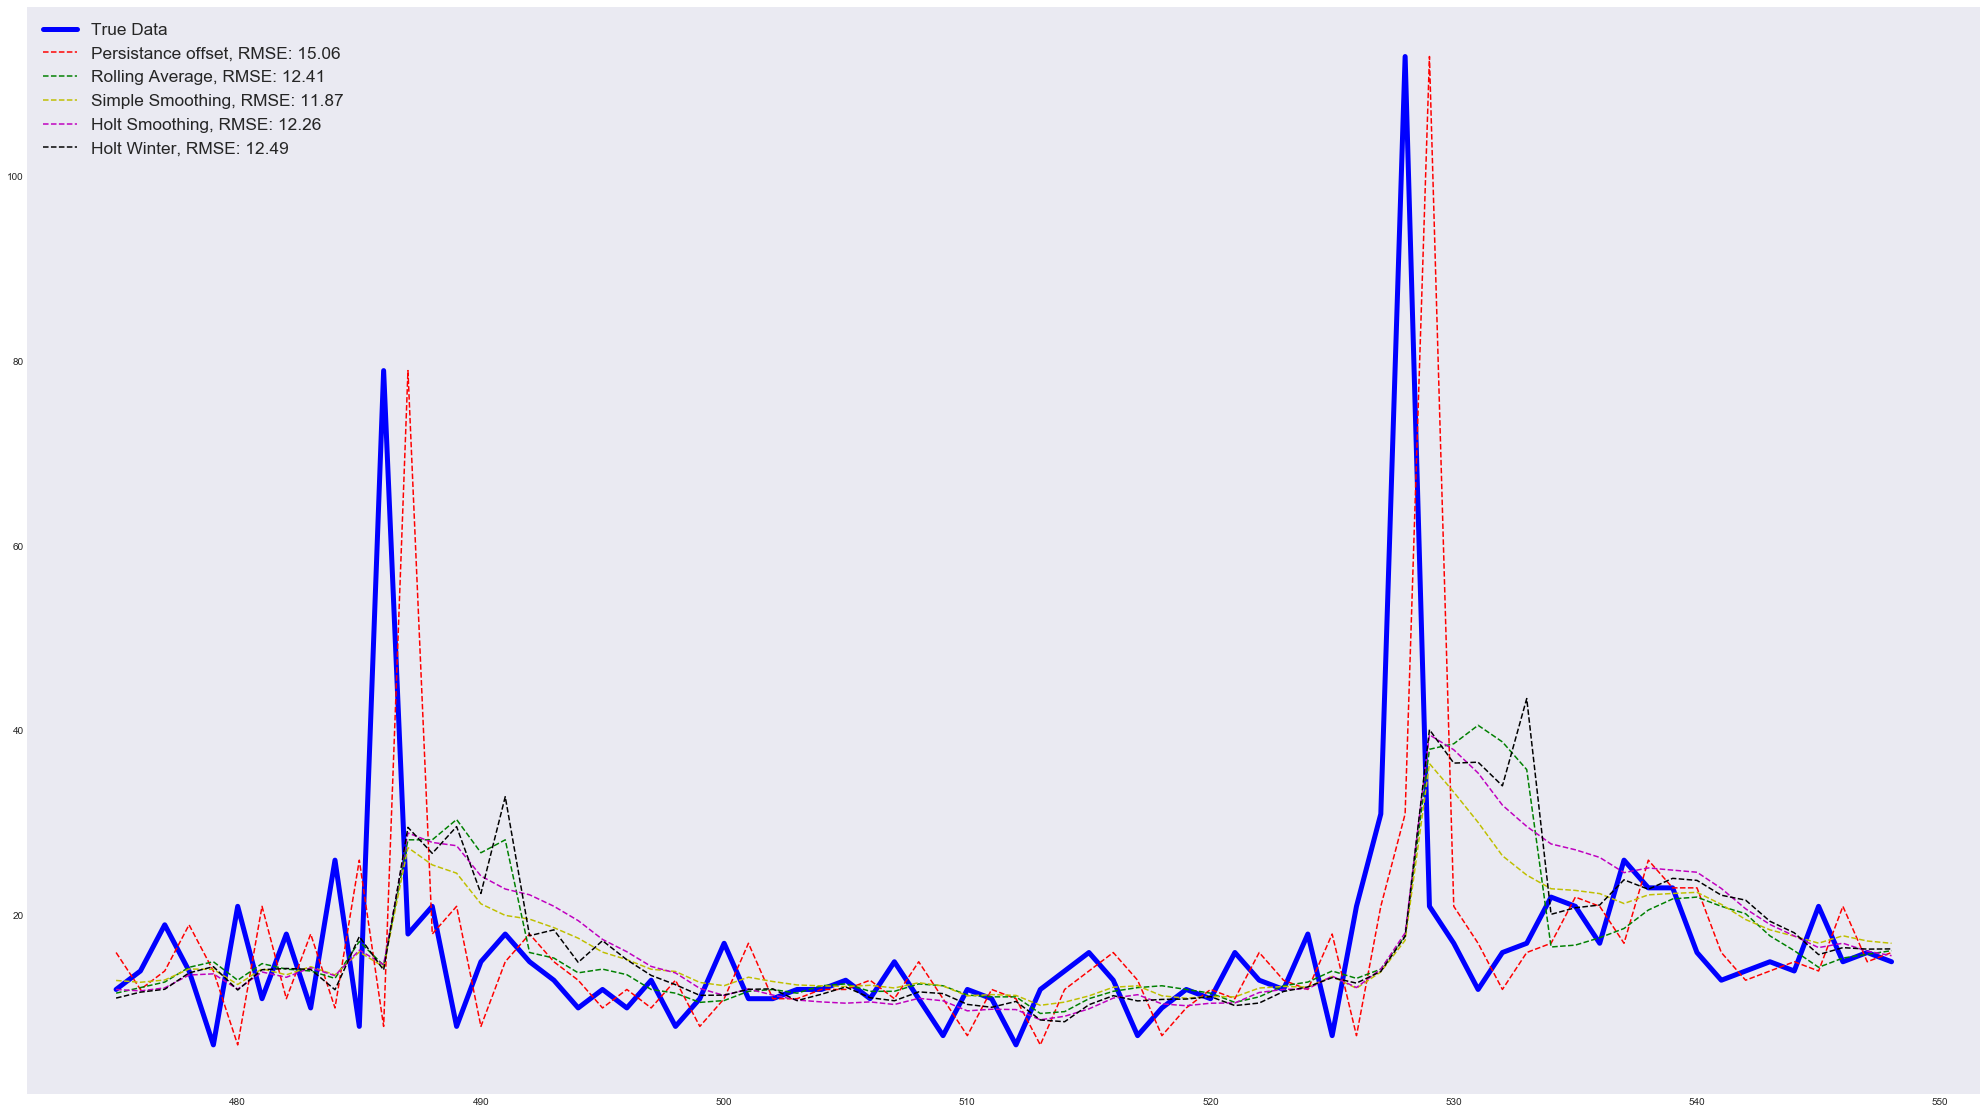

In [16]:
def plot_preds(preds, errors):

    i = 475  # only start plotting after i values for forecasting
    fig = plt.figure(figsize=(35, 20))
    fig.set_facecolor('white')
    plt.style.use('seaborn-dark')
    plt.plot(data_range[i:], data[i:], 'b', linewidth=5, label='True Data')
    plt.plot(data_range[i:], preds['persistance'][i:],     'r--', label='Persistance offset, RMSE: %.2f' % errors['persistance'])
    plt.plot(data_range[i:], preds['rolling'][i:],         'g--', label='Rolling Average, RMSE: %.2f' % errors['rolling'])
    plt.plot(data_range[i:], preds['simple_exp'][i:],      'y--', label='Simple Smoothing, RMSE: %.2f' % errors['simple_exp'])
    plt.plot(data_range[i:], preds['holt_exp'][i:],        'm--', label='Holt Smoothing, RMSE: %.2f' % errors['holt_exp'])
    plt.plot(data_range[i:], preds['holt_winter_exp'][i:], 'k--', label='Holt Winter, RMSE: %.2f' % errors['holt_winter_exp'])
    plt.legend(loc=2, fontsize = 'xx-large')
    plt.show()

plot_preds(preds, error)